<a href="https://www.kaggle.com/code/ritvik1909/feature-tokenizer-transformer/" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Tokenizer Transformer
Featured in the paper [Revisiting Deep Learning Models for Tabular Data (2021, June)](https://arxiv.org/abs/2106.11959) Feature Tokenizer Transformer is a simple adaptation of the Transformer architecture for the tabular domain. In a nutshell, Feature Tokenizer Transformer transforms all features (categorical and numerical) to embeddings and applies a stack of Transformer layers to the embeddings. Thus, every Transformer layer operates on the feature level of one object.

In this notebook we will be implementing Feature Tokenizer Transformer using TensorFlow 2 from scratch.

In [1]:
%%capture
!pip install tensorflow-addons

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow_addons.activations import sparsemax
from tensorflow.data import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from tensorflow.keras import utils

# Data
Loading the train and test csv files into `pandas.DataFrame` and splitting the columns as features and target.

We will be using Stratified K folds as our local cross validation.

In [3]:
data = pd.read_csv('/content/sample_data/california_housing_train.csv')
data['total_rooms'] = (data['total_rooms'] % 10).astype(int).astype(str) # for demonstration purpose we will treat these columns as categorical
data['total_bedrooms'] = (data['total_bedrooms'] % 10).astype(int).astype(str) # for demonstration purpose we will treat these columns as categorical
data['median_house_value'] = data['median_house_value'] // 100_000 # converting the problem for a rgression to a classification problem
print(data.shape)
data.head()

(17000, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,2,3,1015.0,472.0,1.4936,0.0
1,-114.47,34.40,19.0,0,1,1129.0,463.0,1.8200,0.0
2,-114.56,33.69,17.0,0,4,333.0,117.0,1.6509,0.0
3,-114.57,33.64,14.0,1,7,515.0,226.0,3.1917,0.0
4,-114.57,33.57,20.0,4,6,624.0,262.0,1.9250,0.0


In [4]:
test = pd.read_csv('/content/sample_data/california_housing_test.csv')
test['total_rooms'] = (test['total_rooms'] % 10).astype(int).astype(str) # for demonstration purpose we will treat these columns as categorical
test['total_bedrooms'] = (test['total_bedrooms'] % 10).astype(int).astype(str) # for demonstration purpose we will treat these columns as categorical
test['median_house_value'] = test['median_house_value'] // 100_000 # converting the problem for a rgression to a classification problem
print(test.shape)
X_test = test.drop(['median_house_value'], axis=1)
y_test = pd.get_dummies(test['median_house_value'])

(3000, 9)


In [5]:
X = data.drop(['median_house_value'], axis=1)
y = pd.get_dummies(data['median_house_value'])

# Model
**Creating some data utility classes**:

`DataConfig` helps to segregate the features into numeric features and categorical features and maintain a vocabulary for the categorical ones.

`DataLoader` class creates `tf.data.Dataset` objects from `pandas.DataFrame` to ensure efficiency in the input pipeline to the model.

In [6]:
class DataConfig:
    def __init__(self, numeric_feature_names, categorical_features_with_vocabulary):
        self.NUMERIC_FEATURE_NAMES = numeric_feature_names
        self.CATEGORICAL_FEATURES_WITH_VOCABULARY = categorical_features_with_vocabulary
        self.CATEGORICAL_FEATURE_NAMES = list(self.CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
        self.FEATURE_NAMES = self.NUMERIC_FEATURE_NAMES + self.CATEGORICAL_FEATURE_NAMES
        
class DataLoader:
    @classmethod
    def from_df(cls, X, y=None, batch_size=1024):
        return (
            Dataset.from_tensor_slices(({col: X[col].values.tolist() for col in X.columns}, y.values.tolist())).batch(
                batch_size
            )
            if y is not None
            else Dataset.from_tensor_slices({col: X[col].values.tolist() for col in X.columns}).batch(batch_size)
        )        

**Creating Input Layers and Feature Encoding Layers**

`get_inputs` returns a dictionary of Input Layers based on the data types of the feature columns mentioned in the `DataConfig` object.

`encode_inputs` applies StringLookup and Embedding Layer to the categorical features and Reshapes the Numeric Features in order to encode the inputs.

In [7]:
def get_inputs(config):
    return {
        feature_name: L.Input(
            name=feature_name,
            shape=(),
            dtype=(tf.float32 if feature_name in config.NUMERIC_FEATURE_NAMES else tf.string),
        )
        for feature_name in config.FEATURE_NAMES
    }

def encode_inputs(inputs, config, use_embeddings=False, embedding_dim=32, prefix="", concat_features=False):
    cat_features = []
    num_features = []
    for feature_name in inputs:
        if feature_name in config.CATEGORICAL_FEATURE_NAMES:
            vocabulary = config.CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = L.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embeddings else "binary",
                name=f"{prefix}{feature_name}_lookup",
            )
            if use_embeddings:
                encoded_feature = lookup(inputs[feature_name])
                embedding = L.Embedding(
                    input_dim=len(vocabulary),
                    output_dim=embedding_dim,
                    name=f"{prefix}{feature_name}_embeddings",
                )
                encoded_feature = embedding(encoded_feature)
            else:
                encoded_feature = lookup(
                    L.Reshape((1,), name=f"{prefix}{feature_name}_reshape")(inputs[feature_name])
                )
            cat_features.append(encoded_feature)
        else:
            encoded_feature = L.Reshape((1,), name=f"{prefix}{feature_name}_reshape")(inputs[feature_name])
            num_features.append(encoded_feature)

    features = (
        L.Concatenate(name=f"{prefix}inputs_concatenate")(cat_features + num_features)
        if concat_features
        else (cat_features, num_features)
    )

    return features

**Defining Model Configurations**
* Number of Outputs
* Activation of the Output Layer
* Number of Transformer Blocks
* Number of heads in the Transformer Blocks
* Embedding Dimension for the features
* Dimesion of the Dense Projections in the transfomer blocks

In [8]:
class FeatureTokenizerTransformerConfig:
    def __init__(
        self,
        num_outputs,
        out_activation,
        num_transformer_blocks=2,
        num_heads=8,
        embedding_dim=32,
        dense_dim=16,
    ):
        self.NUM_OUT = num_outputs
        self.OUT_ACTIVATION = out_activation
        self.NUM_TRANSFORMER_BLOCKS = num_transformer_blocks
        self.NUM_HEADS = num_heads
        self.EMBEDDING_DIM = embedding_dim
        self.DENSE_DIM = dense_dim

**Defining a standard Transformer Block**

In [9]:
class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([L.Dense(dense_dim, activation="relu"), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)

**Defining the Model**
The model takes Inputs Layers and then encodes the features from the functions defined above, the numerical features are then passed through a Dense layer of the same dimensions as the embeddings of the categorical features.

All the feature embeddings are then stacked and then passed through a series of Transformer Blocks followed by the Global Average Pooling and Final Output Layer

In [10]:
class FeatureTokenizerTransformer:
    @classmethod
    def from_config(cls, data_config, model_config, name):
        inputs = get_inputs(data_config)
        cat_features, num_features = encode_inputs(
            inputs,
            data_config,
            use_embeddings=True,
            embedding_dim=model_config.EMBEDDING_DIM,
            prefix="",
            concat_features=False,
        )
        num_feat_emb = [
            L.Dense(model_config.EMBEDDING_DIM, name=f"{feature_name}_embeddings")
            for _, feature_name in zip(range(len(num_features)), data_config.NUMERIC_FEATURE_NAMES)
        ]
        num_features = [emb(feat) for emb, feat in zip(num_feat_emb, num_features)]

        features = L.Concatenate(axis=1, name="feature_embeddings_stack")(
            [
                L.Reshape((1, 32), name=f"{feat_name}_reshape_2")(feat)
                for feat, feat_name in zip((num_features + cat_features), data_config.FEATURE_NAMES)
            ]
        )

        for _ in range(model_config.NUM_TRANSFORMER_BLOCKS):
            features = TransformerBlock(
                embed_dim=model_config.EMBEDDING_DIM,
                dense_dim=model_config.DENSE_DIM,
                num_heads=model_config.NUM_HEADS,
            )(features)
        features = L.GlobalMaxPooling1D()(features)
        outputs = L.Dense(
            units=model_config.NUM_OUT,
            activation=model_config.OUT_ACTIVATION,
            name="outputs",
        )(features)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return model

**Creating instances of the various classes defined so far**

In [11]:
data_config = DataConfig(
    numeric_feature_names=['longitude', 'latitude', 'housing_median_age', 'population', 'households', 'median_income'], 
    categorical_features_with_vocabulary={
        'total_rooms': [str(i) for i in range(10)],
        'total_bedrooms': [str(i) for i in range(10)],
    }
)
model_config = FeatureTokenizerTransformerConfig(num_outputs=y.shape[1], out_activation='softmax')

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Model: "ftt"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 longitude (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 latitude (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 housing_median_age (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 population (InputLayer)        [(None,)]            0           []                             

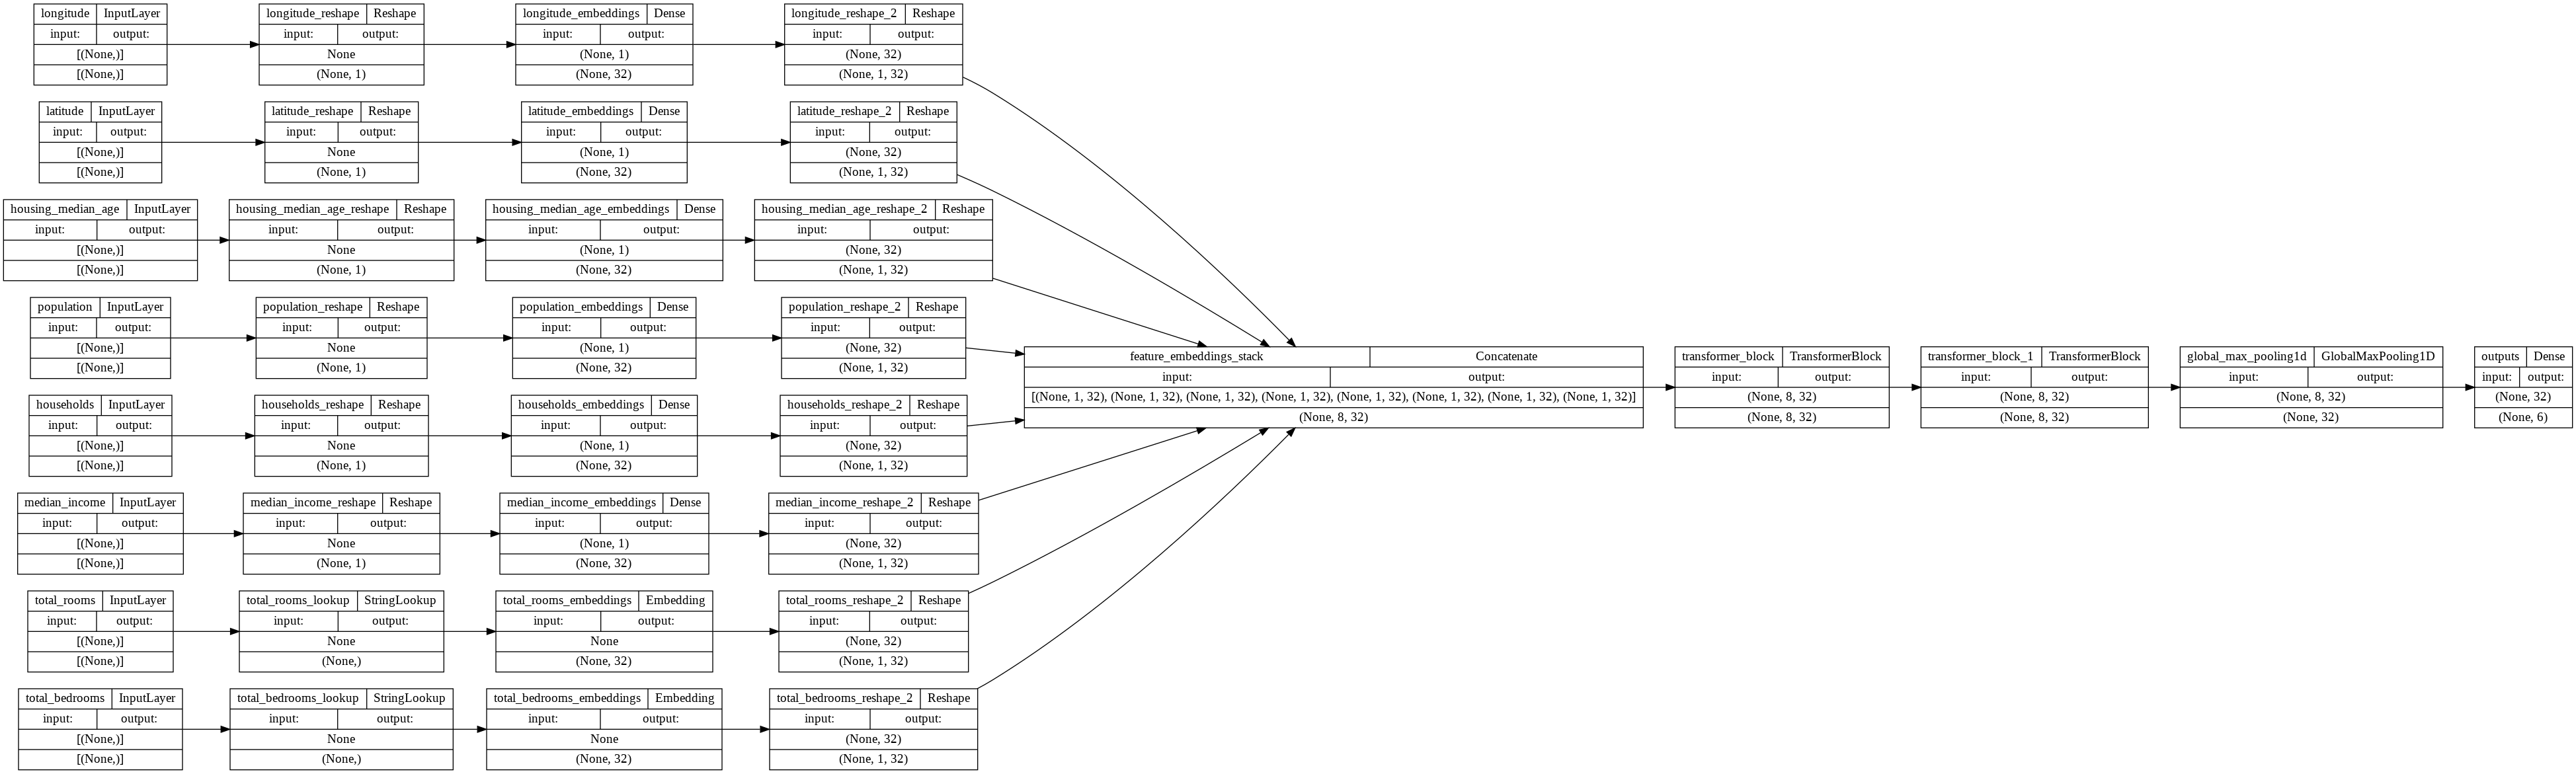

In [12]:
model = FeatureTokenizerTransformer.from_config(data_config, model_config, name='ftt')
model.summary()
utils.plot_model(model, show_shapes=True, expand_nested=True, rankdir='LR')

In [13]:
MAX_EPOCHS  = 10_000

get_callbacks = lambda : [
    keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10, verbose=1, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
    keras.callbacks.CSVLogger("training_log.csv"),
]

In [14]:
get_preprocessor = lambda : ColumnTransformer(
    transformers=[("num", StandardScaler(), data_config.NUMERIC_FEATURE_NAMES)],
    remainder='passthrough'
)

# Training Loop

In [15]:
%%capture
preprocessor = get_preprocessor().fit(X)
X = pd.DataFrame(preprocessor.transform(X), columns=data_config.NUMERIC_FEATURE_NAMES + data_config.CATEGORICAL_FEATURE_NAMES)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=data_config.NUMERIC_FEATURE_NAMES + data_config.CATEGORICAL_FEATURE_NAMES)

for col in data_config.NUMERIC_FEATURE_NAMES:
  X[col] = X[col].astype(float)
  X_test[col] = X_test[col].astype(float)

for col in data_config.CATEGORICAL_FEATURE_NAMES:
  X[col] = X[col].astype(str)
  X_test[col] = X_test[col].astype(str)
    
data_train = DataLoader.from_df(X, y, batch_size=512)
data_test = DataLoader.from_df(X_test, y_test, batch_size=512)
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(
    data_train, validation_data=data_test, callbacks=get_callbacks(), 
    epochs=MAX_EPOCHS
)  
preds = model.predict(data_test)

# Evaluation

In [17]:
confusion_matrix(test['median_house_value'], preds.argmax(axis=1))

array([[357, 144,  11,   0,   0,   0],
       [101, 960, 160,   3,   0,   1],
       [  3, 213, 442,  50,   2,   4],
       [  2,  28, 132, 120,   6,  16],
       [  1,   7,  30,  42,  11,  25],
       [  2,   4,  12,  22,   3,  86]])

In [19]:
print(classification_report(test['median_house_value'], preds.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73       512
         1.0       0.71      0.78      0.74      1225
         2.0       0.56      0.62      0.59       714
         3.0       0.51      0.39      0.44       304
         4.0       0.50      0.09      0.16       116
         5.0       0.65      0.67      0.66       129

    accuracy                           0.66      3000
   macro avg       0.62      0.54      0.55      3000
weighted avg       0.65      0.66      0.65      3000

